## eda + prelim linear regression 
on acled and ucdp data

In [216]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV, MultiTaskElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import matplotlib as plt


In [221]:

acled_df = pd.read_csv('../data/acled/south_sudan.csv') 
acled_df = acled_df.drop(['SOURCE', 'SOURCE_SCALE', 'TAGS'], axis=1)

## darfur: 9316 entries, 32 cols
# print(acled_df.info()) 
# print(acled_df.columns)
# acled_df['FATALITIES']


# ucdp_df = pd.read_csv("../data/ucdp/darfur_113023.csv").drop('low_est', axis=1) ## 1669 entries, 48 cols
# # print(ucdp_df.info()) 
# print(ucdp_df.columns)
# ucdp_df.dropna(inplace=True)
# ucdp_df

In [222]:
acled_df.head()

,EVENT_ID_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,DISORDER_TYPE,EVENT_TYPE,SUB_EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,ADMIN1,ADMIN2,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,NOTES,FATALITIES,TIMESTAMP
0,SSD9476,2023-09-29,2023,1,Demonstrations,Protests,Peaceful protest,Protesters (South Sudan),Teachers (South Sudan),6,...,Jonglei,Bor South,Bor,Bor,6.209,31.559,1,"On 29 September 2023, more than 200 teachers s...",0,1696268002
1,SSD9474,2023-09-28,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Sudan),NaN,3,...,Jonglei,Bor South,Bor,Bor,6.209,31.559,2,"On 28 September 2023, unidentified gunmen atta...",2,1696268002
2,SSD9473,2023-09-27,2023,1,Political violence,Violence against civilians,Attack,Unidentified Armed Group (South Sudan),NaN,3,...,Jonglei,Bor South,Anyidi,Anyidi,6.180,31.811,2,"On 27 September 2023, unidentified gunmen atta...",1,1696268002
3,SSD9468,2023-09-24,2023,2,Political violence,Violence against civilians,Abduction/forced disappearance,Military Forces of Uganda (1986-),NaN,8,...,Central Equatoria,Kajo Keji,Lire,Kajo-Keji,3.850,31.657,2,"Around 24 September 2023 (as reported), UPDF c...",0,1696268002
4,SSD9469,2023-09-24,2023,2,Political violence,Battles,Armed clash,Toposa Ethnic Militia (South Sudan),NaN,4,...,Eastern Equatoria,Kapoeta East,Narus,Nadapal,4.452,34.188,2,"Around 24 September 2023, Toposa Ethnic Militi...",0,1696268002


In [252]:
data = acled_df
X = data.drop('FATALITIES', axis=1)
y = data['FATALITIES']

# data = ucdp_df
# X = data.drop('best_est', axis=1)
# y = data['best_est']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create transformers for numeric and categorical features
## could use Imputer() from sklearn.preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with the preprocessor and a linear regression classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Ridge(alpha=0))
])

# Train the model
model.fit(X_train, y_train)

# Evaluate the model (you can use appropriate metrics for your problem)
## 1 is the best, r^2 score
print("Model score: %.3f" % model.score(X_test, y_test))


Model score: 0.346


In [229]:
# Predict the values using the trained model
y_pred = model.predict(X_test)
y_pred_zero = np.where(model.predict(X_test) < 0, 0, model.predict(X_test))

In [231]:

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')  # Plotting the actual vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Plotting a line for perfect predictions
plt.xlim(0, 40)  # Setting limit for x-axis
plt.ylim(0, 40)  # Setting limit for y-axis
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.title('Actual vs. Predicted Fatalities Visualization')
plt.show()

TypeError: 'module' object is not callable

In [253]:
## evaluating the model 
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_zero)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 307.4759857891063


In [254]:
from sklearn.metrics import r2_score

## the closer to 1 the better
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


R-squared: 0.34550143082553375


In [240]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge
param_grid = {'classifier__alpha': [0, 0.05, 0.1, 0.2, 1, 2, 10]}  # Define the alpha values you want to test

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')  # cv is the number of folds for cross-validation

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate the best model
print("Best Model score: %.3f" % best_model.score(X_test, y_test))
print(f"Best alpha value: {best_model.named_steps['classifier'].alpha}")


Best Model score: 0.346
Best alpha value: 0


In [241]:
best = pd.DataFrame(grid_search.cv_results_)
best

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070828,0.007273,0.013189,0.000146,0,{'classifier__alpha': 0},0.492509,0.237695,-0.072878,0.395697,-0.184779,0.173649,0.262422,1
1,0.068470,0.001154,0.013792,0.000200,0.05,{'classifier__alpha': 0.05},0.490959,0.236632,-0.072886,0.393983,-0.183021,0.173133,0.261225,2
2,0.070263,0.003428,0.013637,0.000297,0.1,{'classifier__alpha': 0.1},0.489368,0.235575,-0.072925,0.392267,-0.181341,0.172589,0.260045,3
3,0.064700,0.001048,0.013198,0.000208,0.2,{'classifier__alpha': 0.2},0.486073,0.233489,-0.073070,0.388853,-0.178180,0.171433,0.257733,4
4,0.060074,0.006548,0.013092,0.000114,1,{'classifier__alpha': 1},0.457586,0.217906,-0.076082,0.362631,-0.160904,0.160227,0.241530,5
5,0.058712,0.007176,0.013296,0.000212,2,{'classifier__alpha': 2},0.423522,0.201409,-0.080190,0.334243,-0.149464,0.145904,0.225382,6
6,0.042501,0.000588,0.013196,0.000199,10,{'classifier__alpha': 10},0.278031,0.136462,-0.079714,0.220679,-0.114851,0.088121,0.158329,7


## raw results

on acled, darfur data:

test size: .2
- linear: LinearRegression()[0.1], Ridge() [0.147], Lasso()[0.052], ElasticNet()[0.05]
- trees: XGBRegressor()[0.25], RandomForestRegressor()[0.356, but takes a long time]
- neural network: MLPRegressor()[-5.803]
- also something called MultiTaskElasticNet() that doesn't work on sparse data 
- ElasticNetCV() does not run 

test size: .3
- LinearRegression() [0.304], Ridge() [0.300], Lasso and EN both [0.047]
- Ridge alpha CV: 0.01 best, basically Ridge << LinearRegression

IndexError: index 3 is out of bounds for axis 0 with size 2

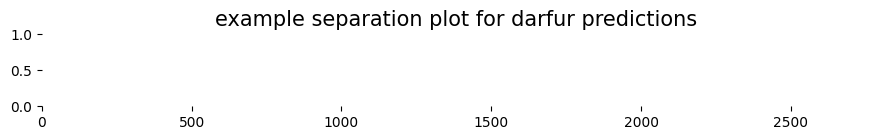

In [203]:
import sepplotlib as spl
## package documentation here: https://pypi.org/project/sepplotlib/
## originally by greenhill et al, a conflicts researcher

df = X_test.copy()
df['y_true'] = list(y_test.values)
df['y_pred'] = y_pred
df.head()


spl.SeparationPlot(
    df=df,
    y_true="y_true",
    y_pred="y_pred",
    title="example separation plot for darfur predictions"
)

In [195]:
## partial dependence plots

from sklearn.inspection import PartialDependenceDisplay
features = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features, kind='both')



TypeError: can't multiply sequence by non-int of type 'float'